In [369]:
# import necessary libraries
import pandas as pd
from bs4 import BeautifulSoup
import requests
import json
import numpy as np

import matplotlib as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium

<h1>Set up the initial data frame </h1>

In [370]:
oakDF = pd.read_csv('/Users/elliott/Documents/IBMDat/Location_Project/Coursera-Capstone/Oaklandzips.csv', sep=';')
oakDF = oakDF[['Zip','Latitude','Longitude']]
oakDF

,Zip,Latitude,Longitude
0,94607,37.806427,-122.288980
1,94602,37.799727,-122.212110
2,94601,37.776835,-122.217920
3,94625,37.803927,-122.319655
4,94619,37.790027,-122.186150
5,94610,37.812377,-122.241990
6,94659,37.680181,-121.921498
7,94609,37.834926,-122.264000
8,94613,37.781098,-122.186573
9,94612,37.809427,-122.271720


Now we need to pull the demographic data about our Oakland zipcodes and attach that to our coordinate data frame.

In [371]:
# Use our list of zipcodes to query website and scrape demographic data for each zipcode
zips = list(oakDF.Zip)
listOfLists = []
for i in zips:
    url = 'https://www.zip-codes.com/zip-code/'+str(i)+'/zip-code-'+str(i)+'.asp'
    request = requests.get(url)
    data = request.text
    soup = BeautifulSoup(data, "html.parser")
    try:
        data = soup.find_all("table")[2].find_all('td')
        numbers = data[1::2]
        titles = data[0::2]
        listOfLists.append([numbers[x].get_text() for x in range(len(numbers))])
    except IndexError:
        print(i, " has missing data")
titles = [titles[x].get_text() for x in range(len(titles))]

94625  has missing data
94643  has missing data
94627  has missing data
94626  has missing data


In [372]:
# remove zipcodes that have no data
oakDF= oakDF[oakDF.Zip!=94625]
oakDF= oakDF[oakDF.Zip!=94643]
oakDF= oakDF[oakDF.Zip!=94627]
oakDF= oakDF[oakDF.Zip!=94626]
oakDF= oakDF[oakDF.Zip!=94666]
oakDF.reset_index()
df = oakDF.join(pd.DataFrame(listOfLists, columns=titles))
df.head()

,Zip,Latitude,Longitude,Current Population:,2010 Population:,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,White Population:,...,Hispanic Population:,Asian Population:,American Indian Population:,Hawaiian Population:,Other Population:,Male Population:,Female Population:,Median Age:,Male Median Age:,Female Median Age:
0,94607,37.806427,-122.28898,"27,642","24,978","10,429","$451,900","$41,870",2.26,"5,874",...,"3,143","7,683",485,122,"1,984","12,585","12,393",36.00 years,35.30 years,36.60 years
1,94602,37.799727,-122.21211,"29,274","28,329","11,702","$673,100","$78,347",2.41,"14,360",...,"3,906","7,396",588,185,"2,036","13,180","15,149",41.30 years,40.20 years,42.40 years
2,94601,37.776835,-122.21792,"53,209","50,294","14,826","$364,500","$44,666",3.34,"14,585",...,"27,039","9,532","1,488",494,"16,939","25,820","24,474",30.90 years,30.40 years,31.70 years
4,94619,37.790027,-122.18615,"30,980","29,287","15,190","$839,100","$87,059",1.91,"18,168",...,"2,494","5,164",483,123,"1,193","13,633","15,654",39.50 years,39.50 years,39.60 years
5,94610,37.812377,-122.24199,0,0,0,$0,$0,0.00,0,...,0,0,0,0,0,0,0,0.00 years,0.00 years,0.00 years


In [373]:
# Pull the "years" out of the age, remove $ signs, and drop the rows with NaN
df[['Male Median Age:','Median Age:','Female Median Age:']] = df[['Male Median Age:','Median Age:','Female Median Age:']].apply(lambda x: x.str.replace('years',''))
df[['Average House Value:','Avg. Income Per Household:']]= df[['Average House Value:','Avg. Income Per Household:']].apply(lambda x: x.str.replace('$',''))
df.dropna(inplace = True)
df

,Zip,Latitude,Longitude,Current Population:,2010 Population:,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,White Population:,...,Hispanic Population:,Asian Population:,American Indian Population:,Hawaiian Population:,Other Population:,Male Population:,Female Population:,Median Age:,Male Median Age:,Female Median Age:
0,94607,37.806427,-122.288980,"27,642","24,978","10,429","451,900","41,870",2.26,"5,874",...,"3,143","7,683",485,122,"1,984","12,585","12,393",36.00,35.30,36.60
1,94602,37.799727,-122.212110,"29,274","28,329","11,702","673,100","78,347",2.41,"14,360",...,"3,906","7,396",588,185,"2,036","13,180","15,149",41.30,40.20,42.40
2,94601,37.776835,-122.217920,"53,209","50,294","14,826","364,500","44,666",3.34,"14,585",...,"27,039","9,532","1,488",494,"16,939","25,820","24,474",30.90,30.40,31.70
4,94619,37.790027,-122.186150,"30,980","29,287","15,190","839,100","87,059",1.91,"18,168",...,"2,494","5,164",483,123,"1,193","13,633","15,654",39.50,39.50,39.60
5,94610,37.812377,-122.241990,0,0,0,0,0,0.00,0,...,0,0,0,0,0,0,0,0.00,0.00,0.00
6,94659,37.680181,-121.921498,"21,944","20,596","9,413","674,700","73,765",2.12,"10,704",...,"2,337","2,184",524,120,"1,150","9,799","10,797",34.60,34.60,34.70
7,94609,37.834926,-122.264000,0,715,5,0,0,5.40,473,...,165,117,28,7,73,74,641,20.60,22.80,20.60
8,94613,37.781098,-122.186573,"16,047","14,389","7,968","535,000","42,880",1.65,"4,592",...,"1,770","4,643",314,85,"1,029","7,476","6,913",40.20,40.80,39.20
9,94612,37.809427,-122.271720,"43,137","39,016","14,757","476,800","66,211",2.63,"9,946",...,"8,675","3,114",953,544,"5,144","18,297","20,719",38.10,36.20,39.50
11,94605,37.763028,-122.163050,"39,220","36,565","16,923","941,900","120,601",2.15,"27,264",...,"2,422","6,491",503,155,925,"17,345","19,220",43.90,43.50,44.20


<h2>Use our Foursquare API to pull venue information about each of our Zipcodes</h2>

In [374]:
CLIENT_ID= '24U0MFBV1QOR411JN2YCVXOSRAX1RJRYNGDCAVYK5II31Z5I'
CLIENT_SECRET= '4SOTX4PYTVHDYMSFWZWNC03CSCAMEDCX5O4WQFP2NBUTY0BT'
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 24U0MFBV1QOR411JN2YCVXOSRAX1RJRYNGDCAVYK5II31Z5I
CLIENT_SECRET:4SOTX4PYTVHDYMSFWZWNC03CSCAMEDCX5O4WQFP2NBUTY0BT


In [375]:
# set up api call with oakland coordinates
latitude = 37.8044
longitude = -122.2712

limit = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    limit)

url

'https://api.foursquare.com/v2/venues/explore?&client_id=24U0MFBV1QOR411JN2YCVXOSRAX1RJRYNGDCAVYK5II31Z5I&client_secret=4SOTX4PYTVHDYMSFWZWNC03CSCAMEDCX5O4WQFP2NBUTY0BT&v=20180605&ll=37.8044,-122.2712&radius=500&limit=100'

In [376]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    

In [377]:
import json
from pandas.io.json import json_normalize

In [378]:
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Oaklandish,Clothing Store,37.805075,-122.270726
1,Analog (Suds & Grub),Sandwich Place,37.804019,-122.270400
2,Golden Lotus Vegetarian Restaurant,Vegetarian / Vegan Restaurant,37.803290,-122.270473
3,Bar Shiru,Bar,37.806378,-122.270393
4,Ume Yoga,Yoga Studio,37.805493,-122.270945
5,Cafe Van Kleef,Bar,37.806660,-122.270273
6,Awaken Cafe,Coffee Shop,37.805217,-122.270618
7,The Hatch,Bar,37.805006,-122.269584
8,Woods Bar & Brewery,Brewery,37.806889,-122.270415
9,Cape & Cowl,Comic Shop,37.806725,-122.272747


In [379]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        neighborhood = requests.get(url).json()['response']['headerLocation']
        # return only relevant information for each nearby venue
        templist = [(
            name, 
            lat, 
            lng, 
            neighborhood,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results]
        venues_list.append(templist)


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zip', 
                  'Zip Latitude', 
                  'Zip Longitude',
                  'Neighborhood',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [380]:
Oakland_venues = getNearbyVenues(names=df['Zip'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )


94607
94602
94601
94619
94610
94659
94609
94613
94612
94605
94606
94611
94624
94660
94615
94649
94623
94617
94604
94661
94614


In [381]:
Oakland_venues.shape

(449, 8)

In [382]:
Oak = Oakland_venues
Oakland_venues= Oak.merge(df, left_on='Zip',right_on='Zip')
Oakland_venues.head()

,Zip,Zip Latitude,Zip Longitude,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category,Latitude,Longitude,...,Hispanic Population:,Asian Population:,American Indian Population:,Hawaiian Population:,Other Population:,Male Population:,Female Population:,Median Age:,Male Median Age:,Female Median Age:
0,94607,37.806427,-122.28898,West Oakland,Full Out Studios,37.803989,-122.290272,Dance Studio,37.806427,-122.28898,...,"3,143","7,683",485,122,"1,984","12,585","12,393",36.00,35.30,36.60
1,94607,37.806427,-122.28898,West Oakland,7th West,37.804128,-122.290732,Bar,37.806427,-122.28898,...,"3,143","7,683",485,122,"1,984","12,585","12,393",36.00,35.30,36.60
2,94607,37.806427,-122.28898,West Oakland,Orbit Coffee & Doughnuts,37.804058,-122.290053,Donut Shop,37.806427,-122.28898,...,"3,143","7,683",485,122,"1,984","12,585","12,393",36.00,35.30,36.60
3,94607,37.806427,-122.28898,West Oakland,Mandela Foods Cooperative,37.805223,-122.294173,Grocery Store,37.806427,-122.28898,...,"3,143","7,683",485,122,"1,984","12,585","12,393",36.00,35.30,36.60
4,94607,37.806427,-122.28898,West Oakland,Lowell Park,37.808292,-122.284985,Park,37.806427,-122.28898,...,"3,143","7,683",485,122,"1,984","12,585","12,393",36.00,35.30,36.60


In [383]:
print('There are {} uniques categories.'.format(len(Oakland_venues['Venue Category'].unique())))

There are 139 uniques categories.


In [384]:
# one hot encoding
Oakland_onehot = pd.get_dummies(Oakland_venues[['Venue Category']], prefix="", prefix_sep="")

# add Zip column back to dataframe
Oakland_onehot['Zip'] = Oakland_venues['Zip'] 

# move Zip column to the first column
fixed_columns = [Oakland_onehot.columns[-1]] + list(Oakland_onehot.columns[:-1])
Oakland_onehot = Oakland_onehot[fixed_columns]

Oakland_onehot.head()

,Zip,Adult Boutique,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,94607,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,94607,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,94607,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,94607,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,94607,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [385]:
Oakland_onehot['Zip'].unique()

array([94607, 94602, 94601, 94619, 94610, 94659, 94609, 94613, 94612,
       94605, 94606, 94611, 94624, 94660, 94615, 94649, 94623, 94617,
       94604, 94661, 94614])

In [386]:
Oakland_grouped = Oakland_onehot
Oakland_grouped = Oakland_grouped.groupby('Zip').mean().reset_index()
Oakland_grouped

,Zip,Adult Boutique,African Restaurant,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Tea Room,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Wine Bar,Yoga Studio
0,94601,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.041667,0.000000,0.000000,0.000000,0.000000
1,94602,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.031250,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,94604,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.5,0.000000,0.000000,0.000000,0.000000,0.000000
3,94605,0.000000,0.000000,0.000000,0.000000,0.000000,0.2,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,94606,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,94607,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
6,94609,0.000000,0.021277,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.021277,...,0.000000,0.042553,0.000000,0.000000,0.0,0.021277,0.000000,0.000000,0.000000,0.021277
7,94610,0.012048,0.000000,0.000000,0.000000,0.036145,0.0,0.000000,0.000000,0.000000,...,0.000000,0.024096,0.000000,0.012048,0.0,0.000000,0.012048,0.012048,0.024096,0.036145
8,94611,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
9,94612,0.000000,0.000000,0.000000,0.000000,0.025641,0.0,0.012821,0.000000,0.012821,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.012821,0.012821,0.025641


In [387]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [388]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zip']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Zips_venues_sorted = pd.DataFrame(columns=columns)
Zips_venues_sorted['Zip'] = Oakland_grouped['Zip']

for ind in np.arange(Oakland_grouped.shape[0]):
    Zips_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Oakland_grouped.iloc[ind, :], num_top_venues)

Zips_venues_sorted

,Zip,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94601,Mexican Restaurant,Grocery Store,Bookstore,Mobile Phone Shop,Liquor Store,Burrito Place,Food Truck,Spa,Bakery,Gas Station
1,94602,Coffee Shop,Grocery Store,Chinese Restaurant,Ice Cream Shop,Café,Pizza Place,Pet Store,Pharmacy,Japanese Restaurant,Liquor Store
2,94604,Trail,Dog Run,Yoga Studio,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Deli / Bodega
3,94605,Light Rail Station,Coffee Shop,Food,Arcade,Liquor Store,Dog Run,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
4,94606,Filipino Restaurant,Liquor Store,Bus Line,Bakery,Mexican Restaurant,Park,Pizza Place,Convenience Store,Cosmetics Shop,Cupcake Shop
5,94607,Bar,Liquor Store,Sandwich Place,Park,Grocery Store,Dance Studio,Donut Shop,Bus Stop,Dog Run,Fast Food Restaurant
6,94609,Korean Restaurant,Pizza Place,Ice Cream Shop,Café,Bookstore,Thai Restaurant,Coffee Shop,Mexican Restaurant,Yoga Studio,Liquor Store
7,94610,Dive Bar,Yoga Studio,Bank,Mobile Phone Shop,Japanese Restaurant,Pizza Place,Nail Salon,Bakery,American Restaurant,Gastropub
8,94611,Moving Target,Reservoir,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Dog Run,Dive Bar,Deli / Bodega,Filipino Restaurant
9,94612,Bar,Sandwich Place,Cocktail Bar,Coffee Shop,Café,Yoga Studio,Caribbean Restaurant,Burger Joint,Beer Garden,Music Venue


In [389]:
# lets cluster our zipcodes by the most commmon venues to find areas that would be most suitable for a health-spa
# create a function to make it easy to for testing
def clusters(df,kclusters):
    temp = df.drop('Zip', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(temp)

    # check cluster labels generated for each row in the dataframe
    print(kmeans.labels_[0:10]) 
    
    return kmeans.labels_
labels = clusters(Oakland_grouped, 5)

[1 2 0 2 1 2 2 2 3 2]


In [390]:
# add clustering labels
Zips_venues_sorted.insert(0, 'Cluster Labels', labels)

Oakland_merged = df[['Zip','Latitude','Longitude']]

# merge Oakland_grouped with Oakland_data to add latitude/longitude for each Zip
Oakland_merged = Oakland_merged.join(Zips_venues_sorted.set_index('Zip'), on='Zip', how='right')

Oakland_merged.head()

,Zip,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94607,37.806427,-122.28898,2,Bar,Liquor Store,Sandwich Place,Park,Grocery Store,Dance Studio,Donut Shop,Bus Stop,Dog Run,Fast Food Restaurant
1,94602,37.799727,-122.21211,2,Coffee Shop,Grocery Store,Chinese Restaurant,Ice Cream Shop,Café,Pizza Place,Pet Store,Pharmacy,Japanese Restaurant,Liquor Store
2,94601,37.776835,-122.21792,1,Mexican Restaurant,Grocery Store,Bookstore,Mobile Phone Shop,Liquor Store,Burrito Place,Food Truck,Spa,Bakery,Gas Station
4,94619,37.790027,-122.18615,4,Home Service,Food,Lake,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Dog Run,Dive Bar
5,94610,37.812377,-122.24199,2,Dive Bar,Yoga Studio,Bank,Mobile Phone Shop,Japanese Restaurant,Pizza Place,Nail Salon,Bakery,American Restaurant,Gastropub


In [391]:
def clusterMap(df,kclusters):
#     Create map
    map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df['Latitude'], df['Longitude'], df['Zip'], df['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return map_clusters
clusterMap(Oakland_merged,5)

Let's examine our clusters to find areas that would be most appropriate for our new health-spa

In [392]:
Oakland_merged.loc[Oakland_merged['Cluster Labels'] == 0]

,Zip,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,94659,37.680181,-121.921498,0,Trail,Dog Run,Yoga Studio,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Deli / Bodega
15,94624,37.680181,-121.921498,0,Trail,Dog Run,Yoga Studio,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Deli / Bodega
16,94660,37.680181,-121.921498,0,Trail,Dog Run,Yoga Studio,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Deli / Bodega
18,94649,37.680181,-121.921498,0,Trail,Dog Run,Yoga Studio,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Deli / Bodega
19,94623,37.680181,-121.921498,0,Trail,Dog Run,Yoga Studio,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Deli / Bodega
21,94604,37.680181,-121.921498,0,Trail,Dog Run,Yoga Studio,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Deli / Bodega
23,94661,37.680181,-121.921498,0,Trail,Dog Run,Yoga Studio,Dive Bar,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Deli / Bodega


Cluster one on closer inspection is going to be a throw away set, as these are all have the same coordinates. After doing some research, these are all PO Boxes. 

In [393]:
Oakland_merged.loc[Oakland_merged['Cluster Labels'] == 1]

,Zip,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,94601,37.776835,-122.21792,1,Mexican Restaurant,Grocery Store,Bookstore,Mobile Phone Shop,Liquor Store,Burrito Place,Food Truck,Spa,Bakery,Gas Station
12,94606,37.793177,-122.24352,1,Filipino Restaurant,Liquor Store,Bus Line,Bakery,Mexican Restaurant,Park,Pizza Place,Convenience Store,Cosmetics Shop,Cupcake Shop


Cluster 1 appears to have the types of venues that are similar in nature to our health-spa

In [394]:
Oakland_merged.loc[Oakland_merged['Cluster Labels'] == 2]

,Zip,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,94607,37.806427,-122.288980,2,Bar,Liquor Store,Sandwich Place,Park,Grocery Store,Dance Studio,Donut Shop,Bus Stop,Dog Run,Fast Food Restaurant
1,94602,37.799727,-122.212110,2,Coffee Shop,Grocery Store,Chinese Restaurant,Ice Cream Shop,Café,Pizza Place,Pet Store,Pharmacy,Japanese Restaurant,Liquor Store
5,94610,37.812377,-122.241990,2,Dive Bar,Yoga Studio,Bank,Mobile Phone Shop,Japanese Restaurant,Pizza Place,Nail Salon,Bakery,American Restaurant,Gastropub
7,94609,37.834926,-122.264000,2,Korean Restaurant,Pizza Place,Ice Cream Shop,Café,Bookstore,Thai Restaurant,Coffee Shop,Mexican Restaurant,Yoga Studio,Liquor Store
8,94613,37.781098,-122.186573,2,Intersection,Print Shop,Concert Hall,Soccer Field,Art Museum,Tea Room,Bus Stop,Pool,Sushi Restaurant,Ethiopian Restaurant
9,94612,37.809427,-122.271720,2,Bar,Sandwich Place,Cocktail Bar,Coffee Shop,Café,Yoga Studio,Caribbean Restaurant,Burger Joint,Beer Garden,Music Venue
11,94605,37.763028,-122.163050,2,Light Rail Station,Coffee Shop,Food,Arcade,Liquor Store,Dog Run,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant
17,94615,37.806677,-122.300380,2,Liquor Store,Park,Bus Station,Harbor / Marina,Food,Latin American Restaurant,Light Rail Station,Metro Station,Cosmetics Shop,Music Venue
20,94617,37.807827,-122.271652,2,Bar,Coffee Shop,Sandwich Place,Cocktail Bar,Café,Music Venue,Bagel Shop,American Restaurant,Mexican Restaurant,Burger Joint
24,94614,37.727739,-122.204573,2,Airport Service,Airport Terminal,Rental Car Location,Gym,Shipping Store,Hotel,Hotel Pool,Indian Restaurant,Sports Bar,Yoga Studio


In [395]:
Oakland_merged.loc[Oakland_merged['Cluster Labels'] == 3]

,Zip,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,94611,37.827126,-122.22289,3,Moving Target,Reservoir,Yoga Studio,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Dog Run,Dive Bar,Deli / Bodega,Filipino Restaurant


In [396]:
Oakland_merged.loc[Oakland_merged['Cluster Labels'] == 4]

,Zip,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,94619,37.790027,-122.18615,4,Home Service,Food,Lake,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Dog Run,Dive Bar


Now lets cluster based on demographics and then find our commonalities

In [397]:
df

,Zip,Latitude,Longitude,Current Population:,2010 Population:,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,White Population:,...,Hispanic Population:,Asian Population:,American Indian Population:,Hawaiian Population:,Other Population:,Male Population:,Female Population:,Median Age:,Male Median Age:,Female Median Age:
0,94607,37.806427,-122.288980,"27,642","24,978","10,429","451,900","41,870",2.26,"5,874",...,"3,143","7,683",485,122,"1,984","12,585","12,393",36.00,35.30,36.60
1,94602,37.799727,-122.212110,"29,274","28,329","11,702","673,100","78,347",2.41,"14,360",...,"3,906","7,396",588,185,"2,036","13,180","15,149",41.30,40.20,42.40
2,94601,37.776835,-122.217920,"53,209","50,294","14,826","364,500","44,666",3.34,"14,585",...,"27,039","9,532","1,488",494,"16,939","25,820","24,474",30.90,30.40,31.70
4,94619,37.790027,-122.186150,"30,980","29,287","15,190","839,100","87,059",1.91,"18,168",...,"2,494","5,164",483,123,"1,193","13,633","15,654",39.50,39.50,39.60
5,94610,37.812377,-122.241990,0,0,0,0,0,0.00,0,...,0,0,0,0,0,0,0,0.00,0.00,0.00
6,94659,37.680181,-121.921498,"21,944","20,596","9,413","674,700","73,765",2.12,"10,704",...,"2,337","2,184",524,120,"1,150","9,799","10,797",34.60,34.60,34.70
7,94609,37.834926,-122.264000,0,715,5,0,0,5.40,473,...,165,117,28,7,73,74,641,20.60,22.80,20.60
8,94613,37.781098,-122.186573,"16,047","14,389","7,968","535,000","42,880",1.65,"4,592",...,"1,770","4,643",314,85,"1,029","7,476","6,913",40.20,40.80,39.20
9,94612,37.809427,-122.271720,"43,137","39,016","14,757","476,800","66,211",2.63,"9,946",...,"8,675","3,114",953,544,"5,144","18,297","20,719",38.10,36.20,39.50
11,94605,37.763028,-122.163050,"39,220","36,565","16,923","941,900","120,601",2.15,"27,264",...,"2,422","6,491",503,155,925,"17,345","19,220",43.90,43.50,44.20


In [398]:
# format rows to remove commas and change data type
columns=['Current Population:','Households per ZIP Code:', 'Average House Value:',
       'Avg. Income Per Household:', 'Persons Per Household:','Male Population:',
       'Female Population:']

df[columns]= df[columns].apply(lambda x: x.str.replace(',','')).astype('float64')

demosDF = df[['Zip','Latitude','Longitude','Households per ZIP Code:', 'Average House Value:',
       'Avg. Income Per Household:', 'Persons Per Household:','Male Population:',
       'Female Population:']]

In [399]:
clabels = clusters(demosDF,3)

[2 1 2 1 0 1 0 2 2 1]


In [400]:
demosDF.insert(0, 'Cluster Labels', clabels)

In [401]:
clusterMap(demosDF,3)

In [402]:
# Now we need to examine the demographic clusters and compare with our venue clusters 

In [403]:
# here we see that 94609 might be the only actual zip code that is not a PO Box, 
# this could be a usable zip code as it is likely mostly made up of businesses

demosDF.loc[demosDF['Cluster Labels'] == 0]

,Cluster Labels,Zip,Latitude,Longitude,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,Male Population:,Female Population:
5,0,94610,37.812377,-122.241990,0.0,0.0,0.0,0.0,0.0,0.0
7,0,94609,37.834926,-122.264000,5.0,0.0,0.0,5.4,74.0,641.0
12,0,94606,37.793177,-122.243520,0.0,0.0,0.0,0.0,0.0,0.0
13,0,94611,37.827126,-122.222890,0.0,0.0,0.0,0.0,0.0,0.0
15,0,94624,37.680181,-121.921498,0.0,0.0,0.0,0.0,0.0,0.0
16,0,94660,37.680181,-121.921498,0.0,0.0,0.0,0.0,0.0,0.0
17,0,94615,37.806677,-122.300380,0.0,0.0,0.0,0.0,0.0,0.0
18,0,94649,37.680181,-121.921498,0.0,0.0,0.0,0.0,0.0,0.0
19,0,94623,37.680181,-121.921498,0.0,0.0,0.0,0.0,0.0,0.0
20,0,94617,37.807827,-122.271652,0.0,0.0,0.0,0.0,0.0,0.0


In [404]:
# Cluster 1 is a well populated lower income area
demosDF.loc[demosDF['Cluster Labels'] == 1]

,Cluster Labels,Zip,Latitude,Longitude,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,Male Population:,Female Population:
1,1,94602,37.799727,-122.212110,11702.0,673100.0,78347.0,2.41,13180.0,15149.0
4,1,94619,37.790027,-122.186150,15190.0,839100.0,87059.0,1.91,13633.0,15654.0
6,1,94659,37.680181,-121.921498,9413.0,674700.0,73765.0,2.12,9799.0,10797.0
11,1,94605,37.763028,-122.163050,16923.0,941900.0,120601.0,2.15,17345.0,19220.0


In [405]:
# This is our high income area
demosDF.loc[demosDF['Cluster Labels'] == 2]

,Cluster Labels,Zip,Latitude,Longitude,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,Male Population:,Female Population:
0,2,94607,37.806427,-122.288980,10429.0,451900.0,41870.0,2.26,12585.0,12393.0
2,2,94601,37.776835,-122.217920,14826.0,364500.0,44666.0,3.34,25820.0,24474.0
8,2,94613,37.781098,-122.186573,7968.0,535000.0,42880.0,1.65,7476.0,6913.0
9,2,94612,37.809427,-122.271720,14757.0,476800.0,66211.0,2.63,18297.0,20719.0
21,2,94604,37.680181,-121.921498,8473.0,246800.0,34566.0,3.49,14789.0,15081.0
24,2,94614,37.727739,-122.204573,8860.0,307500.0,49793.0,3.52,15430.0,15973.0


In [406]:
# Create a new column that shows the average income per person
demosDF['Average Income/person:'] = demosDF['Avg. Income Per Household:'].div(demosDF['Persons Per Household:'],0)

/Users/elliott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [407]:
# find our high income Zipcodes
highIncomeDF = demosDF[demosDF['Cluster Labels']==1]
# remove 94659 as it is Pleasonton, which is too far
highIncomeDF = highIncomeDF[highIncomeDF['Zip']!=94659]
highIncomeDF

,Cluster Labels,Zip,Latitude,Longitude,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,Male Population:,Female Population:,Average Income/person:
1,1,94602,37.799727,-122.21211,11702.0,673100.0,78347.0,2.41,13180.0,15149.0,32509.128631
4,1,94619,37.790027,-122.18615,15190.0,839100.0,87059.0,1.91,13633.0,15654.0,45580.628272
11,1,94605,37.763028,-122.16305,16923.0,941900.0,120601.0,2.15,17345.0,19220.0,56093.488372


In [408]:
# Now let's find the venues most similar to our proposed venue and map them onto our zipcodes
competitionDF = Oak[Oak['Zip'].isin(highIncomeDF['Zip'])]
# get rid of 94659 as it is Pleasonton
competitionDF = competitionDF[competitionDF['Zip']!=94659]
competitionDF

,Zip,Zip Latitude,Zip Longitude,Neighborhood,Venue,Venue Latitude,Venue Longitude,Venue Category
10,94602,37.799727,-122.21211,Upper Dimond,La Farine Boulangerie Patisserie,37.799439,-122.216495,Bakery
11,94602,37.799727,-122.21211,Upper Dimond,Dimond Slice,37.800424,-122.215835,Pizza Place
12,94602,37.799727,-122.21211,Upper Dimond,Flavor Brigade,37.800998,-122.215733,Ice Cream Shop
13,94602,37.799727,-122.21211,Upper Dimond,Jade Palace,37.799336,-122.212154,Chinese Restaurant
14,94602,37.799727,-122.21211,Upper Dimond,Taqueria Los Comales,37.800503,-122.217119,Burrito Place
15,94602,37.799727,-122.21211,Upper Dimond,Cafe Umami,37.800349,-122.215580,Café
16,94602,37.799727,-122.21211,Upper Dimond,Farmer Joe’s,37.799479,-122.216238,Grocery Store
17,94602,37.799727,-122.21211,Upper Dimond,Peet's Coffee & Tea,37.799352,-122.216703,Coffee Shop
18,94602,37.799727,-122.21211,Upper Dimond,Paws and Claws,37.800239,-122.217318,Pet Store
19,94602,37.799727,-122.21211,Upper Dimond,Grand Lake Kitchen,37.800924,-122.217454,Restaurant


In [409]:
# Create a map to examine the our selected areas and the competition in those areas

def makeMapOfCompetition(highIncomeDF,competitionDF):
    mapa = folium.Map(location=[latitude, longitude], zoom_start=10)

    # add markers to map
    for Zip, lat, lng in zip(highIncomeDF['Zip'],highIncomeDF['Latitude'], highIncomeDF['Longitude']):
        label = '{}'.format(Zip)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(mapa)  

    for Zip ,venue, ven_cat, lat, lng, Neighborhood in zip(
        competitionDF['Zip'],competitionDF['Venue'],competitionDF['Venue Category'],
        competitionDF['Venue Latitude'], competitionDF['Venue Longitude'],competitionDF['Neighborhood']):
        label2 = '{}, \n {}, \n {}, \n {}'.format(Zip, Neighborhood, venue, ven_cat)
        label2 = folium.Popup(label2, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label2,
            color='red',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(mapa)  
        

    return mapa
makeMapOfCompetition(highIncomeDF, competitionDF)    

In [410]:
# add the Neighborhood names to make Zip codes easier to understand
x = competitionDF[['Zip','Neighborhood']]
highIncomeDF = highIncomeDF.merge(x.drop_duplicates(subset='Zip'), left_on='Zip', right_on='Zip', how='left')
cols = list(highIncomeDF.columns.values) 
cols.pop(cols.index('Neighborhood')) 
highIncomeDF = highIncomeDF[['Neighborhood']+cols]

In [426]:
# show df dataframe to give us age data as well
display = df[df['Zip'].isin(highIncomeDF['Zip'])]
display[['Zip','Current Population:','2010 Population:','Households per ZIP Code:','Average House Value:','Avg. Income Per Household:','Persons Per Household:','Male Population:','Female Population:','Median Age:','Male Median Age:','Female Median Age:']]
        

,Zip,Current Population:,2010 Population:,Households per ZIP Code:,Average House Value:,Avg. Income Per Household:,Persons Per Household:,Male Population:,Female Population:,Median Age:,Male Median Age:,Female Median Age:
1,94602,29274.0,"28,329",11702.0,673100.0,78347.0,2.41,13180.0,15149.0,41.30,40.20,42.40
4,94619,30980.0,"29,287",15190.0,839100.0,87059.0,1.91,13633.0,15654.0,39.50,39.50,39.60
11,94605,39220.0,"36,565",16923.0,941900.0,120601.0,2.15,17345.0,19220.0,43.90,43.50,44.20


In [412]:
# and now or competition the most common venues within these zip codes
Oakland_merged[Oakland_merged['Zip'].isin(highIncomeDF['Zip'])]

,Zip,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,94602,37.799727,-122.21211,2,Coffee Shop,Grocery Store,Chinese Restaurant,Ice Cream Shop,Café,Pizza Place,Pet Store,Pharmacy,Japanese Restaurant,Liquor Store
4,94619,37.790027,-122.18615,4,Home Service,Food,Lake,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant,Donut Shop,Dog Run,Dive Bar
11,94605,37.763028,-122.16305,2,Light Rail Station,Coffee Shop,Food,Arcade,Liquor Store,Dog Run,Filipino Restaurant,Fast Food Restaurant,Falafel Restaurant,Ethiopian Restaurant


In [455]:
params = {'legend.fontsize': 20,
          'figure.figsize': (15, 5),
         'axes.labelsize': 20,
         'axes.titlesize':30,
         'xtick.labelsize':20,
         'ytick.labelsize':20}
plt.rcParams.update(params)

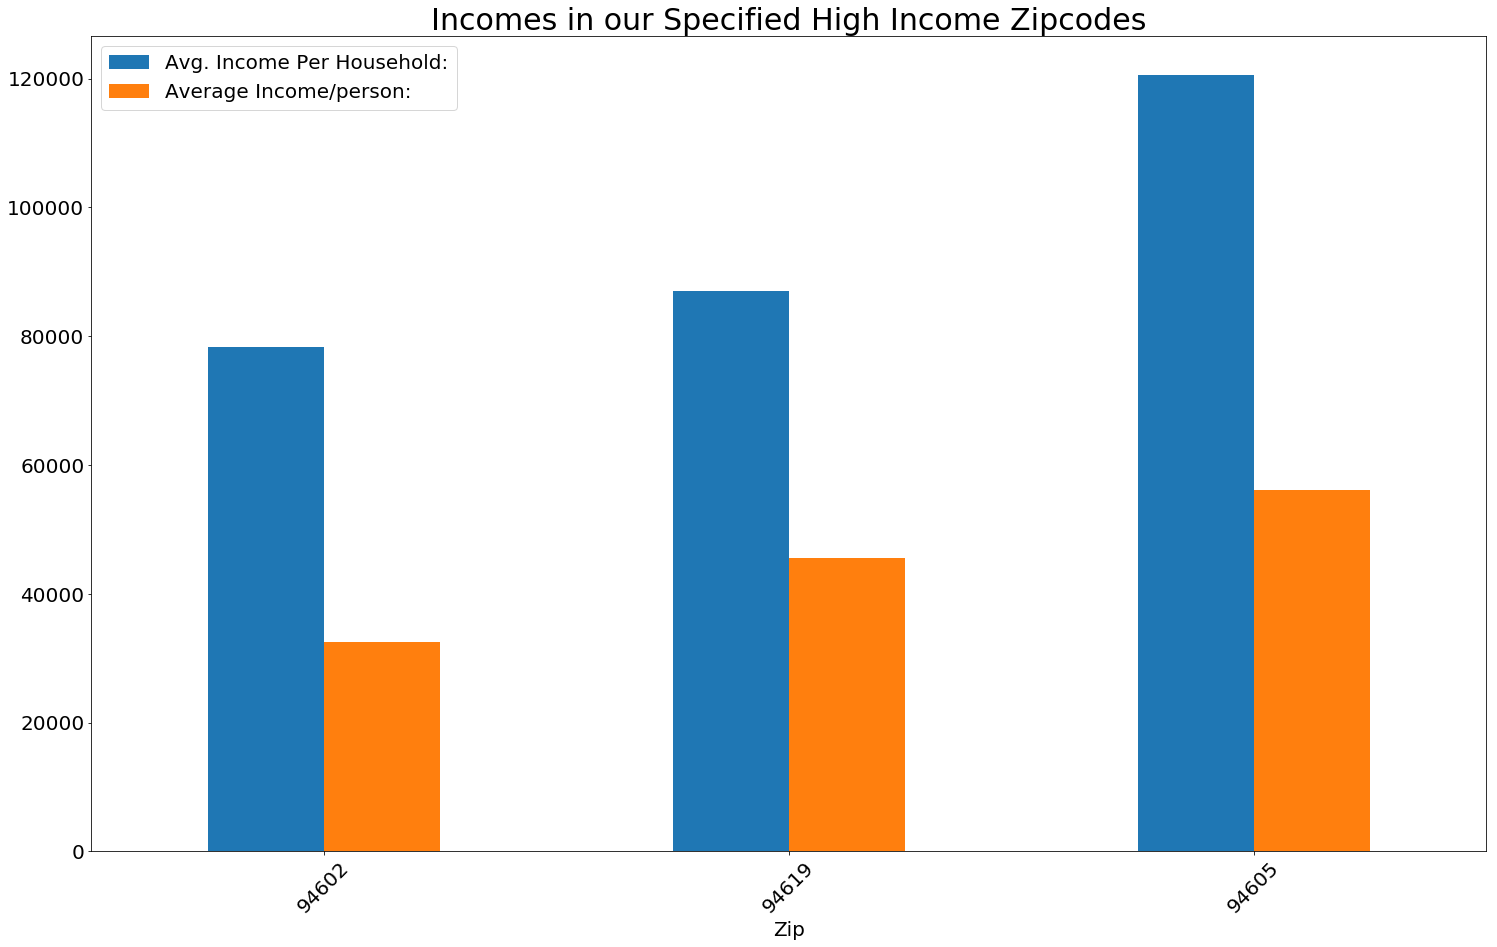

In [459]:
income = highIncomeDF[['Zip','Avg. Income Per Household:','Average Income/person:']]
income.plot(kind='bar',figsize=(25,15),x='Zip',title='Incomes in our Specified High Income Zipcodes',
           rot=45)#.legend(loc=2, prop={'size': 20})

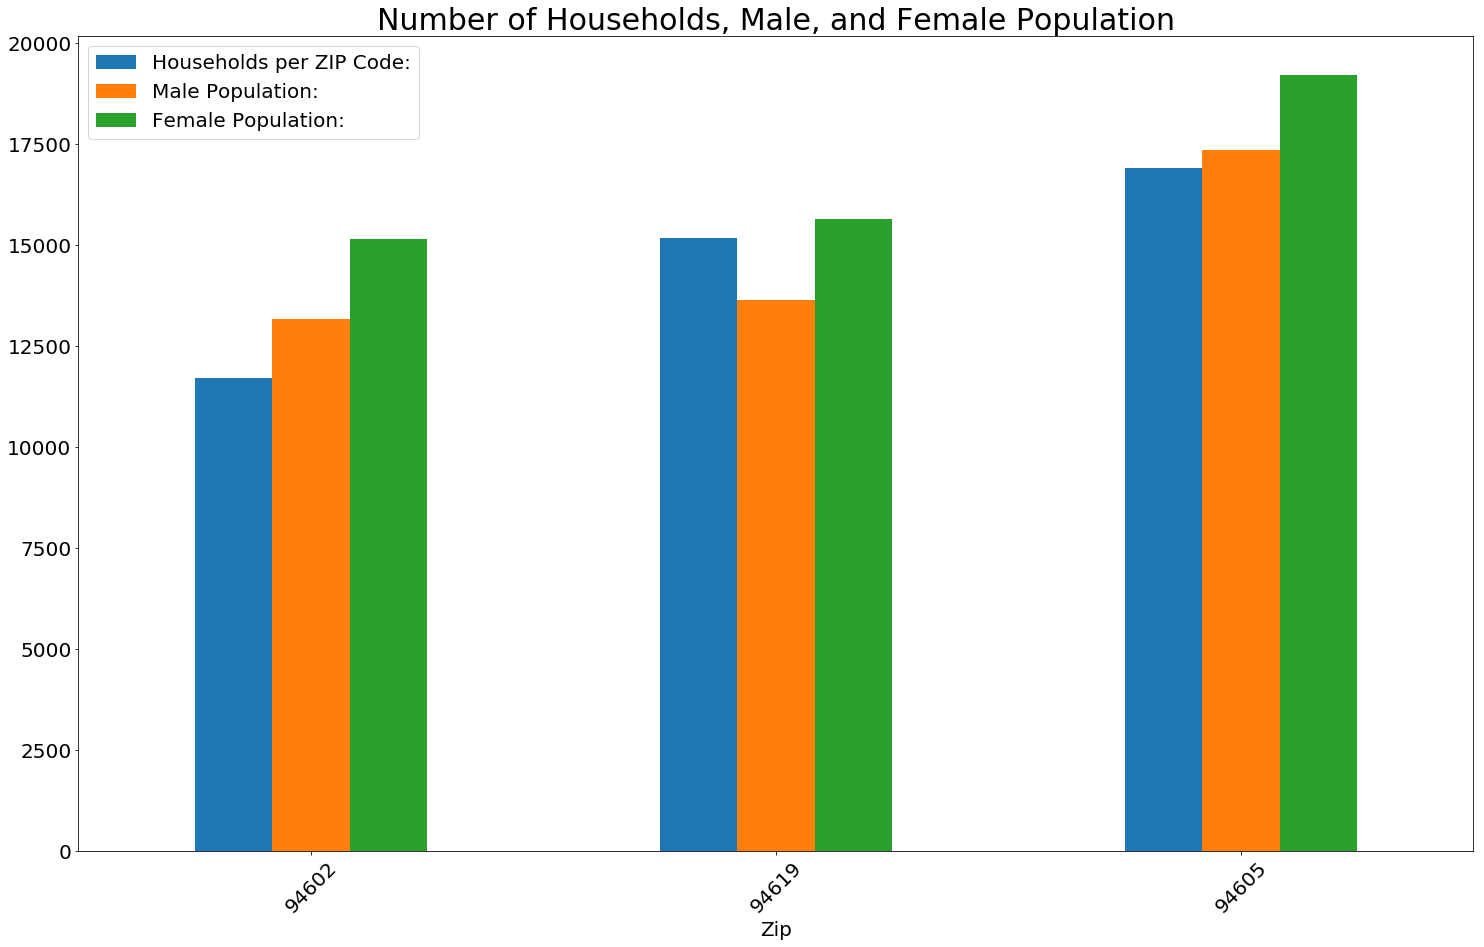

In [460]:
demo = highIncomeDF[['Zip','Households per ZIP Code:','Male Population:','Female Population:']]
demo.plot(kind='bar',figsize=(25,15),x='Zip',fontsize=20,title='Number of Households, Male, and Female Population',
           rot=45)